# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score

from art.utils import load_cifar10
from art.defences.preprocessor import CutMixTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
tf.config.run_functions_eagerly(True)

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# CutMix

In [3]:
cutmix = CutMixTensorFlowV2(num_classes=10, apply_fit=True, apply_predict=False)

In [4]:
cutmix_train = cutmix.forward(x=x_train, y=y_train)

In [6]:
cutmix_test = cutmix.forward(x=x_test, y=y_test)

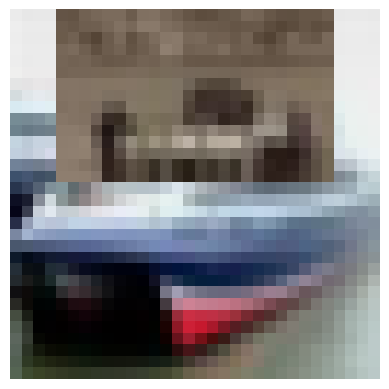

In [11]:
plt.figure()
plt.imshow(cutmix_test[0][1])
plt.axis("off")
plt.show()

# Model

In [12]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
normal_model = create_model()

In [14]:
augmented_model = create_model()

# Train - Normal Model

In [15]:
history = normal_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

/home/alper/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
391/391 [==============================] - 20s 47ms/step - loss: 1.4540 - accuracy: 0.4763 - val_loss: 1.1014 - val_accuracy: 0.6079
Epoch 2/10
391/391 [==============================] - 17s 44ms/step - loss: 0.9815 - accuracy: 0.6544 - val_loss: 0.9498 - val_accuracy: 0.6723
Epoch 3/10
391/391 [==============================] - 17s 44ms/step - loss: 0.7779 - accuracy: 0.7264 - val_loss: 0.8341 - val_accuracy: 0.7150
Epoch 4/10
391/391 [==============================] - 17s 44ms/step - loss: 0.6212 - accuracy: 0.7838 - val_loss: 0.7508 - val_accuracy: 0.7434
Epoch 5/10
391/391 [==============================] - 17s 44ms/step - loss: 0.4765 - accuracy: 0.8346 - val_loss: 0.7616 - val_accuracy: 0.7491
Epoch 6/10
391/391 [==============================] - 17s 44ms/step - loss: 0.3421 - accuracy: 0.8810 - val_loss: 0.8524 - val_accuracy: 0.7445
Epoch 7/10
391/391 [==============================] - 17s 45ms/step - loss: 0.2216 - accuracy: 0.9229 - val_loss: 0.9412 - val_accuracy:

# Train - Augmented Model

In [17]:
history = augmented_model.fit(cutmix_train[0], y_train, batch_size=128, epochs=10, validation_data=(cutmix_test[0], y_test))

Epoch 1/10
391/391 [==============================] - 18s 45ms/step - loss: 1.4948 - accuracy: 0.4600 - val_loss: 1.4875 - val_accuracy: 0.4969
Epoch 2/10
391/391 [==============================] - 18s 47ms/step - loss: 1.0496 - accuracy: 0.6281 - val_loss: 1.3481 - val_accuracy: 0.5636
Epoch 3/10
391/391 [==============================] - 18s 46ms/step - loss: 0.8786 - accuracy: 0.6897 - val_loss: 1.3416 - val_accuracy: 0.5775
Epoch 4/10
391/391 [==============================] - 17s 45ms/step - loss: 0.7298 - accuracy: 0.7448 - val_loss: 1.3658 - val_accuracy: 0.5804
Epoch 5/10
391/391 [==============================] - 18s 46ms/step - loss: 0.5927 - accuracy: 0.7911 - val_loss: 1.3142 - val_accuracy: 0.5964
Epoch 6/10
391/391 [==============================] - 18s 46ms/step - loss: 0.4433 - accuracy: 0.8449 - val_loss: 1.4550 - val_accuracy: 0.5904
Epoch 7/10
391/391 [==============================] - 18s 46ms/step - loss: 0.2882 - accuracy: 0.9012 - val_loss: 1.8675 - val_accuracy:

# Test 

In [18]:
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

In [19]:
normal_pred1 = normal_model.predict(x_test, verbose=0)
normal_pred1 = np.argmax(normal_pred1, axis=1)

In [20]:
normal_pred2 = normal_model.predict(cutmix_test[0], verbose=0)
normal_pred2 = np.argmax(normal_pred2, axis=1)

In [21]:
augmented_pred1 = augmented_model.predict(x_test, verbose=0)
augmented_pred1 = np.argmax(augmented_pred1, axis=1)

In [22]:
augmented_pred2 = augmented_model.predict(cutmix_test[0], verbose=0)
augmented_pred2 = np.argmax(augmented_pred2, axis=1)

# Results

In [23]:
print("Normal Model Accuracy (Normal Data):", accuracy_score(y_test_true, normal_pred1))
print("Normal Model Accuracy (Augmented Data):", accuracy_score(y_test_true, normal_pred2))

Normal Model Accuracy (Normal Data): 0.7281
Normal Model Accuracy (Augmented Data): 0.5596


In [24]:
print("Augmented Model Accuracy (Normal Data):", accuracy_score(y_test_true, augmented_pred1))
print("Augmented Model Accuracy (Augmented Data):", accuracy_score(y_test_true, augmented_pred2))

Augmented Model Accuracy (Normal Data): 0.7434
Augmented Model Accuracy (Augmented Data): 0.5887
